# *Program is to estimate the petrol consumption*

Petrol_tax, Average_income, Paved_Highways,Population_Driver_licence(%) are the features 

and 

Petrol_Consumption is the Target or Label 

Steps required for installation spark in google colab

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [59]:
# Reading the csv file by using spark

df_spark = spark.read.csv('petrol_consumption.csv', inferSchema=True, header=True)
print(type(df_spark))

<class 'pyspark.sql.dataframe.DataFrame'>


In [60]:
df_spark.printSchema() # print detail schema of data
df_spark.show()# show top 20 rows
# Do more operation on it.

root
 |-- Petrol_tax: double (nullable = true)
 |-- Average_income: integer (nullable = true)
 |-- Paved_Highways: integer (nullable = true)
 |-- Population_Driver_licence(%): double (nullable = true)
 |-- Petrol_Consumption: integer (nullable = true)

+----------+--------------+--------------+----------------------------+------------------+
|Petrol_tax|Average_income|Paved_Highways|Population_Driver_licence(%)|Petrol_Consumption|
+----------+--------------+--------------+----------------------------+------------------+
|       9.0|          3571|          1976|                       0.525|               541|
|       9.0|          4092|          1250|                       0.572|               524|
|       9.0|          3865|          1586|                        0.58|               561|
|       7.5|          4870|          2351|                       0.529|               414|
|       8.0|          4399|           431|                       0.544|               410|
|      10.0|       

In [61]:
# print rows and columns in spark like shape in pandas 
print((df_spark.count(), len(df_spark.columns)))

(48, 5)


In [62]:
# Calculate statistical varables for columns 
df_spark.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Petrol_tax,48,7.668333333333333,0.9507697516051803,5.0,10.0
Average_income,48,4241.833333333333,573.6237677697417,3063,5342
Paved_Highways,48,5565.416666666667,3491.5071660788753,431,17782
Population_Driver_licence(%),48,0.5703333333333334,0.05547026549972456,0.451,0.724
Petrol_Consumption,48,576.7708333333334,111.88581557530142,344,968


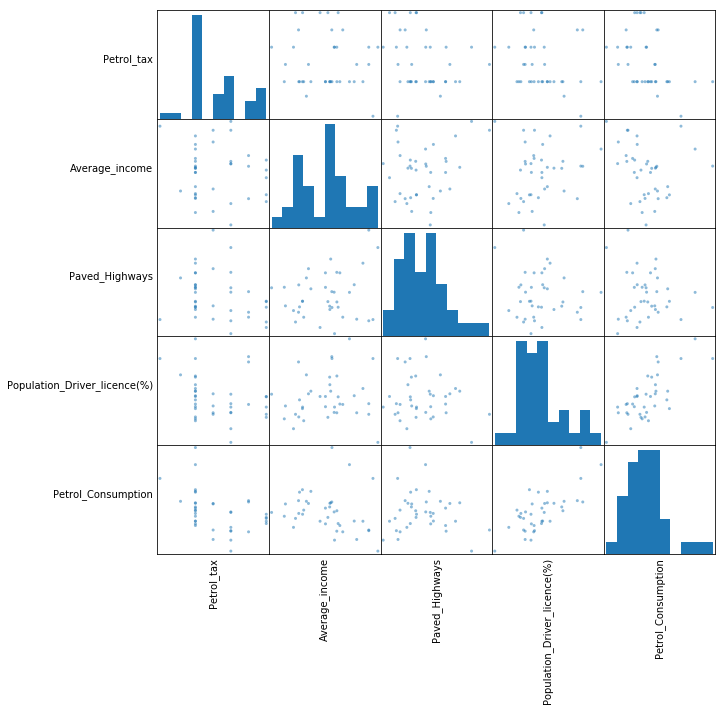

In [63]:
# Plot scatter matrix between the columns 
import pandas as pd
from pandas.plotting import scatter_matrix
numeric_features = [t[0] for t in df_spark.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df_spark.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [64]:
# Correlation matrix between the input features and petrol consumptions
import six
for i in df_spark.columns:
    if not( isinstance(df_spark.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Petrol Consumption for ", i, df_spark.stat.corr('Petrol_Consumption',i))

Correlation to Petrol Consumption for  Petrol_tax -0.45128027518698666
Correlation to Petrol Consumption for  Average_income -0.24486207498269938
Correlation to Petrol Consumption for  Paved_Highways 0.01904193881958566
Correlation to Petrol Consumption for  Population_Driver_licence(%) 0.6989654213627082
Correlation to Petrol Consumption for  Petrol_Consumption 1.0


# Prepare Data for Machine Learning Divide data into two columns only for spark one for features and second one for Label [Petrol Consumption]

In [65]:
# Spark support only two columns during training one for features and second one is labels
# Vector Assembler is used to assemble all the features used for training 
# Petrol consumption in the label where to train a regression model for estimating the 
# petrol consumption
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Petrol_tax', 'Average_income', 'Paved_Highways', 'Population_Driver_licence(%)'], outputCol = 'features')
petrol_df = vectorAssembler.transform(df_spark)
petrol_df = petrol_df.select(['features', 'Petrol_Consumption'])
petrol_df.show(3)

+--------------------+------------------+
|            features|Petrol_Consumption|
+--------------------+------------------+
|[9.0,3571.0,1976....|               541|
|[9.0,4092.0,1250....|               524|
|[9.0,3865.0,1586....|               561|
+--------------------+------------------+
only showing top 3 rows



In [0]:
# Splitting data into training and testing 80% training and 20% testing
weights = [.8, .2]
seed = 42 # seed=0L
rawTrainData, rawValidationData = petrol_df.randomSplit(weights, seed)

Linear Regression

In [67]:
# training the linear regression madel
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='Petrol_Consumption', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(rawTrainData)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-33.58623546148529,-0.07817081237526403,-0.00201926718463608,1381.4236830362772]
Intercept: 390.2708065961913


In [68]:
# Summary of the training data 
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 63.469792
r2: 0.649963


In [69]:
rawTrainData.describe().show()

+-------+------------------+
|summary|Petrol_Consumption|
+-------+------------------+
|  count|                42|
|   mean| 574.7380952380952|
| stddev|108.57818572713207|
|    min|               410|
|    max|               968|
+-------+------------------+



In [70]:
# Testing the trained linear regression model
lr_predictions = lr_model.transform(rawValidationData)
lr_predictions.select("prediction","Petrol_Consumption","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Petrol_Consumption",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+------------------+--------------------+
|       prediction|Petrol_Consumption|            features|
+-----------------+------------------+--------------------+
|704.7609692316238|               782|[6.0,5215.0,2302....|
|725.1645061142436|               644|[6.58,3802.0,7834...|
|589.9791423011592|               554|[7.0,3333.0,6594....|
|606.2606460995255|               635|[7.0,4318.0,10340...|
|662.7890592194274|               587|[7.0,4449.0,4639....|
+-----------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.78816


In [71]:
# Calculate the RMSE between the prediction and petolconsumption for test dataset
test_result = lr_model.evaluate(rawValidationData)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 60.4854


Decision Tree Regression

In [72]:
# Training and testing the decision tree model and calculating the RMSE error
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='Petrol_Consumption')
dt_model = dt.fit(rawTrainData)
dt_predictions = dt_model.transform(rawValidationData)
dt_evaluator = RegressionEvaluator(
    labelCol="Petrol_Consumption", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 85.5821


Gradient Boosting tree Regression

In [73]:
# Training and testing the Gradient Boosting model
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol='Petrol_Consumption')
gbt_model = gbt.fit(rawTrainData)
gbt_predictions = gbt_model.transform(rawValidationData)
gbt_predictions.select('prediction', 'Petrol_Consumption', 'features').show(5)

+-----------------+------------------+--------------------+
|       prediction|Petrol_Consumption|            features|
+-----------------+------------------+--------------------+
|866.4075488565418|               782|[6.0,5215.0,2302....|
|552.7948437272926|               644|[6.58,3802.0,7834...|
|553.6260988382546|               554|[7.0,3333.0,6594....|
|647.7452567085594|               635|[7.0,4318.0,10340...|
|648.5521705228448|               587|[7.0,4449.0,4639....|
+-----------------+------------------+--------------------+
only showing top 5 rows



In [74]:
# calculting the RMSE for gradient boosting model 
gbt_evaluator = RegressionEvaluator(
    labelCol="Petrol_Consumption", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 76.0806


**Random Forest **

In [75]:
# Training and testing the Random Forest model
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol = 'features', labelCol='Petrol_Consumption')
rf_model = rf.fit(rawTrainData)
rf_predictions = rf_model.transform(rawValidationData)
rf_predictions.select('prediction', 'Petrol_Consumption', 'features').show(5)

+-----------------+------------------+--------------------+
|       prediction|Petrol_Consumption|            features|
+-----------------+------------------+--------------------+
|            802.2|               782|[6.0,5215.0,2302....|
|619.6575505050504|               644|[6.58,3802.0,7834...|
|543.6544047619047|               554|[7.0,3333.0,6594....|
|590.9553571428571|               635|[7.0,4318.0,10340...|
|672.0864393939394|               587|[7.0,4449.0,4639....|
+-----------------+------------------+--------------------+
only showing top 5 rows



In [76]:
# calculting the RMSE for Random Forest model 
rf_evaluator = RegressionEvaluator(
    labelCol="Petrol_Consumption", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 76.7769
